[0]	validation_0-rmse:1162132.46232	validation_1-rmse:919515.73083
[100]	validation_0-rmse:708851.18859	validation_1-rmse:666503.83108
[200]	validation_0-rmse:544168.49051	validation_1-rmse:606785.35928
[300]	validation_0-rmse:460659.75950	validation_1-rmse:596740.11772
[400]	validation_0-rmse:410305.59652	validation_1-rmse:588075.09005
[500]	validation_0-rmse:376689.33238	validation_1-rmse:586092.76257
[600]	validation_0-rmse:350855.66507	validation_1-rmse:584719.55713
[700]	validation_0-rmse:326253.04529	validation_1-rmse:583130.12750
[781]	validation_0-rmse:311011.64719	validation_1-rmse:582942.53629
R^2: 0.5592
MAE: 442154.23 MWh/día


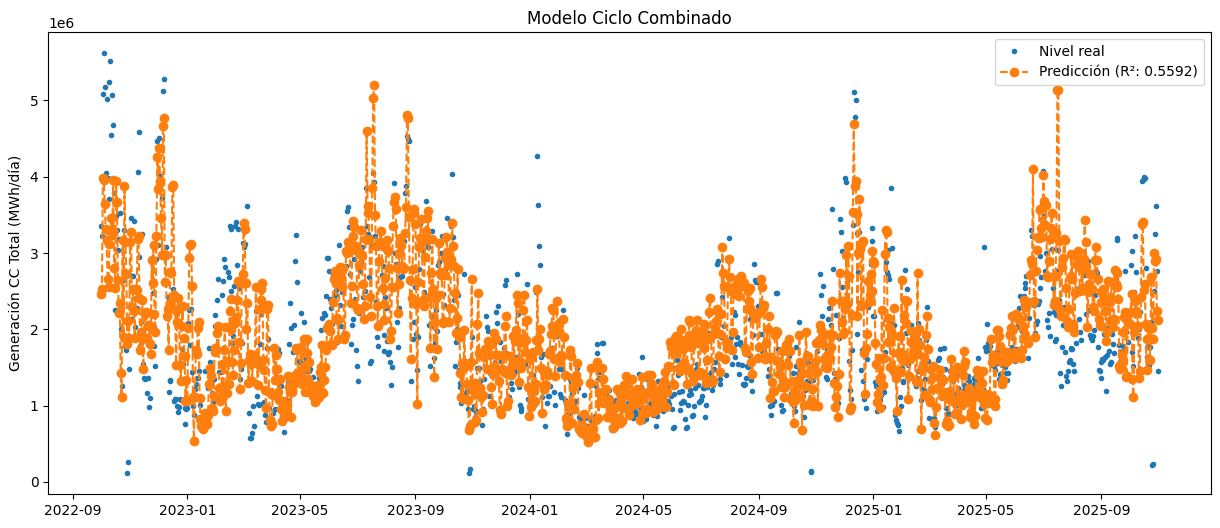

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os

df_5min = pd.read_parquet('../data/2_processed/dataset_maestro_5min.parquet')
df_5min = df_5min.sort_index()

agg_dict = {
    'cc': 'sum',         
    
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',
    
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
}
df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'cc': 'cc_total_dia'})

df_1d['cc_total_lag_7d'] = df_1d['cc_total_dia'].shift(7)
df_1d['cc_total_lag_14d'] = df_1d['cc_total_dia'].shift(14)
df_1d['cc_total_mean_28d'] = df_1d['cc_total_dia'].shift(7).rolling(window=28).mean() # Media de 4 semanas

df_1d = df_1d.dropna()

TARGET_NIVEL = 'cc_total_dia'
FEATURES_NIVEL = [
    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'viento_nacional_ponderado',
    'precipitacion_nacional_ponderada',
    
    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',
    
    'cc_total_lag_7d',
    'cc_total_lag_14d',
    'cc_total_mean_28d'
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2022-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]
X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_cc = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4, 
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_cc.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100)

MODEL_PATH = '../models/modelo_cc.json'
model_nivel_cc.save_model(MODEL_PATH)

preds_nivel = model_nivel_cc.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.', linestyle='None')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo ciclo combinado')
plt.ylabel('Generación CC total (MWh/día)')
plt.legend()
plt.show()